# Develop regression models

In [1]:
import os

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn import preprocessing
import tensorflow as tf
import tensorflow_probability as tfp

### Load data

In [2]:
DATA_DIR = '/home/daitran/Desktop/git/soil_properties/data'

In [3]:
ntb_data_path = os.path.join(DATA_DIR, 'NTB_black_data.csv')
tb_data_path = os.path.join(DATA_DIR, 'TB_blue_data.csv')

In [4]:
ntb_data= pd.read_csv(ntb_data_path)
tb_data = pd.read_csv(tb_data_path)

### Data pre-processing

In [5]:
ntb_names = ntb_data['Soi properties (main)']
tb_names = tb_data['Soi properties (main)']

In [6]:
assign_num_list = {'topsoil layer': 0,
                      'weathered rock': 1,
                      'hard rock': 2,
                      'soft rock': 3,
                      'weathered soil': 4,
                      'colluvial layer': 5,
                      'moderate rock': 6,
                      'sedimentary layer': 7,
                      'reclaimed layer': 8}

In [7]:
ntb_target = ntb_names.replace(assign_num_list)
tb_target = tb_names.replace(assign_num_list)

In [8]:
ntb_data['Target'] = ntb_target
tb_data['Target'] = tb_target

In [9]:
X_train_ntb = ntb_data[['X','Y','Elevation']].to_numpy()
y_train_ntb = ntb_data['Target'].to_numpy()

X_train_tb = tb_data[['X','Y','Elevation']].to_numpy()
y_train_tb = tb_data['Target'].to_numpy()

In [10]:
# https://scikit-learn.org/stable/modules/preprocessing.html
# Minmax scaler
# Standart Scaler
# 

normalizer = preprocessing.MinMaxScaler()

normalized_X_train_ntb = normalizer.fit_transform(X_train_ntb)
normalized_X_train_tb = normalizer.fit_transform(X_train_tb)
# normalized_train_X

# Deterministic Models

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

###  Shallow ANN

In [12]:
model = Sequential()
model.add(Dense(10, input_dim=3, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=3, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=3, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
model.fit(normalized_X_train_ntb, y_train_ntb, epochs = 1000, verbose=0)

## Predict and 3D visualize

### Create test area

In [43]:
test_area = np.empty((0,3), int)
row = np.array([])
for x in tqdm(range(549699, 551000,10)):
    for y in range(213765, 214000,5):
        for elevation in range(90, 130, 5):
            row = np.array([x,y,elevation])
            row = np.expand_dims(row,axis=0)
#             print(row.shape)
            test_area = np.append(test_area, row, axis = 0)
test_area.shape
#             print( row)
#             print('Locationx: {}, y: {}, elevation: {}'.format(x,y,elevation))

100%|██████████| 131/131 [00:01<00:00, 86.92it/s]


(49256, 3)

In [44]:
len(test_area)

49256

In [45]:
normalized_X_test = normalizer.fit_transform(test_area)

In [46]:
results = []
for i in tqdm(range(len(test_area))):
    test_location = normalized_X_test[i]
    test_location = np.expand_dims(test_location, axis =0)
    result = model.predict(test_location)
    results.append(int(result))

100%|██████████| 49256/49256 [21:29<00:00, 38.18it/s]


In [47]:
def plot_data(x, y, labels, colours):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    for c in np.unique(y):
        inx = np.where(y == c)
        ax.scatter(x[inx, 0], x[inx, 1], x[inx, 2], label=labels[c], c=colours[c])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
    

In [48]:
assign_num_list = {'topsoil layer': 0,
                      'weathered rock': 1,
                      'hard rock': 2,
                      'soft rock': 3,
                      'weathered soil': 4,
                      'colluvial layer': 5,
                      'moderate rock': 6,
                      'sedimentary layer': 7,
                      'reclaimed layer': 8}

In [49]:
labels = {}
for k, v in assign_num_list.items():
    labels[v] = k

In [50]:
label_colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink']

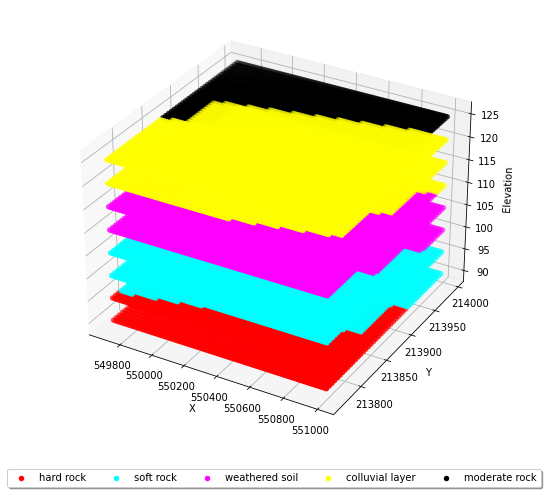

In [51]:
plot_data(test_area, results, labels, label_colours)
plt.show()

## 